In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/TrainrBergomiTermStructure.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:11]
yy=dat[:,11:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

print(xx.shape)
print(yy.shape)

(80000, 11)
(80000, 88)


In [2]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
scale_x = StandardScaler()
scale_y=  StandardScaler()

def xtransform(x_train, x_test):
    return [scale_x.fit_transform(x_train),scale_x.transform(x_test)]

def xinversetransform(x):
    return scale_x.inverse_transform(x)

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,4,0,0.5])
lb=np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.5,-1,0.025])
def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =64,shuffle=True)

device is cuda


In [3]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':11,'hidden_dim':128,'hidden_nums':20,'output_dim':88,'block_layer_nums':3}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)

loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.0001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 17.087049281067266
test loss is 15.050562108415429
Batch: 100,train loss is: 0.6570942083217719
test loss is 0.6343738499279701
Batch: 200,train loss is: 0.28602484113487237
test loss is 0.2995262259176762
Batch: 300,train loss is: 0.1579416196200996
test loss is 0.1706016700040488
Batch: 400,train loss is: 0.12056312204426237
test loss is 0.11601863494115706
Batch: 500,train loss is: 0.08241320061768281
test loss is 0.08785157348131613
Batch: 600,train loss is: 0.06176959841207296
test loss is 0.06512747578067064
Batch: 700,train loss is: 0.05392936270976745
test loss is 0.05551924968697351
Batch: 800,train loss is: 0.05008317221408018
test loss is 0.047684220832865824
Batch: 900,train loss is: 0.04893676815780939
test loss is 0.041235896968425514
Batch: 1000,train loss is: 0.03440494657873989
test loss is 0.03708547497897231
-----------------------Epoch: 1----------------------------------
Batch

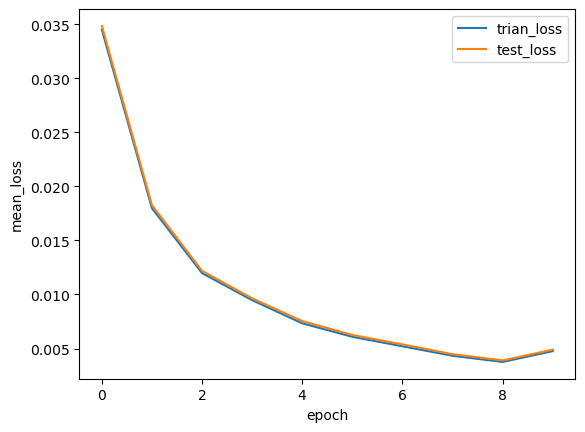

In [4]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.0042774633965603414
test loss is 0.00359074282519737
Batch: 100,train loss is: 0.002632272598438796
test loss is 0.002978459098295502
Batch: 200,train loss is: 0.002708580872824699
test loss is 0.002969436859391617
Batch: 300,train loss is: 0.002896856133408974
test loss is 0.0029889401256892093
Batch: 400,train loss is: 0.0034580509404994932
test loss is 0.0029180880149728863
Batch: 500,train loss is: 0.003162438829055634
test loss is 0.002985608095369215
Batch: 600,train loss is: 0.0026525961750140667
test loss is 0.0029529847273671627
Batch: 700,train loss is: 0.0026943875323476177
test loss is 0.002974003756064377
Batch: 800,train loss is: 0.002770624707489699
test loss is 0.0029541181076673763
Batch: 900,train loss is: 0.0025319020403715762
test loss is 0.0029417831168820005
Batch: 1000,train loss is: 0.003034052878378161
test loss is 0.0028828531872992624
-----------------------Epoch: 1---

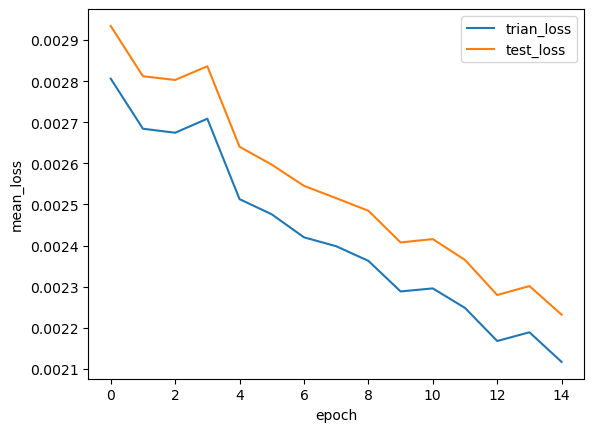

In [5]:
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.00001)

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,15)

In [6]:
torch.save(model.state_dict(),'../../Data/YU/rpiecewiseBergomi.pth')